# Пайплайн для выделения лучших кропов по текстовому запросу Yolo -> Clip -> Annoy

Все расчеты ниже получены по **valid** выборке датасета LVIS

* Применяем модель YoloV5L к датасету, получаем кропы для картинок
* Применяем модель clip к каждому кропу, получаем эмбеддинги кропов
* Применяем модель clip к описанию категорий датасета LVIS, получаем эмбеддинги категорий
* Строим индекс annoy по эмбеддингам кропов для поиска ближайших соседей из кропов к каждой категории датасета
* Проводим анализ метрик

В дальнейшем полученный индекс annoy будет использоваться в ДЕМО для поиска подходящих кропов (из valid части датасета LVIS) для текстового запроса пользователя

In [1]:
ANNOY_SIZE = 500
import setproctitle
setproctitle.setproctitle(f"YOLO_{ANNOY_SIZE}")

In [2]:
import sys

sys.path.append("../yolov5")

In [3]:
from assh_utils import Batch, get_iou, load_json, nms

In [4]:
from yolo_utils import CustomWrapper, DetectMultiBackend

In [5]:
import os

root = "/home/asciishell/s3/asciishell-fsod/LVIS/"
js = load_json("/home/asciishell/s3/asciishell-fsod/LVIS/lvis_v1_val.json.zip")
images = [root + x["coco_url"].replace("http://images.cocodataset.org/", "") for x in js["images"]]
assert all([os.path.exists(x) for x in images[:100]])

In [6]:
import itertools
import math
import os
import pickle

import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
from annoy import AnnoyIndex
from sklearn.cluster import KMeans
from sklearn.metrics import average_precision_score
from tqdm.cli import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
%matplotlib inline

cpu


In [7]:
embeddings = np.load("/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid_emb.npy")
images = pd.read_pickle("/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid.done.pkl.zip")

In [8]:
categories_emb = np.load("/home/asciishell/s3/asciishell-fsod/RunYolo/categories_emb.npy")
categories = pd.read_pickle("/home/asciishell/s3/asciishell-fsod/RunYolo/categories.pkl.zip")

In [9]:
t = AnnoyIndex(embeddings.shape[1], "angular")
for i, v in enumerate(tqdm(embeddings)):
    t.add_item(i, v)

100%|██████████| 852831/852831 [00:35<00:00, 23765.93it/s]


In [10]:
t.build(ANNOY_SIZE)
# t.save(f"/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid_{ANNOY_SIZE}.ann")

True

In [11]:
# t = AnnoyIndex(512, "angular")
# t.load(f"/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid_{ANNOY_SIZE}.ann", prefault=True)

## Проводим анализ метрик
Определим, относятся ли в действительности выделенные кропы к заданной категории (с помощью iou) и вычислим метрики качества.

In [12]:
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

In [13]:
metrics = []
annotation = pd.DataFrame(js['annotations'])
for index, category in tqdm(categories.iterrows(), total=categories.shape[0]):
    best = t.get_nns_by_vector(categories_emb[index], 30, search_k=-1, include_distances=True) # сколько есть максимально объектов каждой категории:
    x_conf = images.loc[best[0], 'confidence']
    tp = []
    x_iou = []
    for x in best[0]: # имеет ли смысл убрать кропы с одной картинки с большим iou?
        img = images.loc[x]
        for ann in annotation[annotation['image_id'] == int(img['image'][-16:-4])].iterrows():
            ann = ann[1]
            iou = get_iou({'x1': img['xmin'], 'x2': img['xmax'], 'y1': img['ymin'], 'y2': img['ymax']}, 
                    {'x1': ann['bbox'][0], 'x2': ann['bbox'][0] + ann['bbox'][2], 'y1': ann['bbox'][1], 'y2': ann['bbox'][1] + ann['bbox'][3]})
            if iou > 0.5 and ann['category_id'] == category['id']: # стоит ли рассматривать разные iou?
                x_iou.append(iou)
                tp.append(1)
                break
        else:
            x_iou.append(None)
            tp.append(0)
            
    for n_neighb in [1, 5, 10, 20, 30]: 
        metrics.append({
                        'category_id': category['id'], 
                        'category_name': category['name'],
                        'n_neighb': n_neighb,
                        'average_precision_conf': average_precision_score(tp[:n_neighb], x_conf[:n_neighb]),
                        'average_precision_dist': average_precision_score(tp[:n_neighb], 1 / np.array(best[1][:n_neighb])),
                        'average_precision_multi': average_precision_score(tp[:n_neighb], np.array(x_conf[:n_neighb]) / np.array(best[1][:n_neighb])),
                        'tp': np.sum(tp[:n_neighb]),
                        'dist_mean': np.mean(best[1][:n_neighb]), 
                        'conf_mean': np.mean(x_conf[:n_neighb]), 
                        'iou_mean': np.mean([x for x in x_iou[:n_neighb] if x is not None], dtype=np.float64), 
                       })
    # break
metrics = pd.DataFrame(metrics)
metrics.to_pickle(f'/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid_metrics_{ANNOY_SIZE}.pkl.zip')

100%|██████████| 1203/1203 [02:51<00:00,  7.01it/s]


In [14]:
metrics = pd.read_pickle(f"/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid_metrics_{ANNOY_SIZE}.pkl.zip")

In [15]:
metrics["accuracy"] = metrics["tp"] / metrics["n_neighb"]

In [16]:
metrics.head()

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
0,1,aerosol_can,1,NaN,NaN,...,0,1.139319,0.022353,NaN,0.0
1,1,aerosol_can,5,NaN,NaN,...,0,1.147435,0.020082,NaN,0.0
2,1,aerosol_can,10,NaN,NaN,...,0,1.152949,0.098385,NaN,0.0
3,1,aerosol_can,20,NaN,NaN,...,0,1.157850,0.131217,NaN,0.0
4,1,aerosol_can,30,NaN,NaN,...,0,1.160560,0.231234,NaN,0.0


In [17]:
# в топе по accuracy простые и понятные категории (животные, популярные предметы)
metrics_ = metrics[metrics["n_neighb"] == 10]
metrics_.sort_values("accuracy", ascending=False).head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
2222,445,fireplug,10,1.000000,1.000000,...,10,1.109402,0.336446,0.858066,1.0
5092,1019,stop_sign,10,1.000000,1.000000,...,10,1.136286,0.487233,0.950317,1.0
2442,489,gazelle,10,1.000000,1.000000,...,10,1.181319,0.040229,0.775797,1.0
2107,422,elephant,10,1.000000,1.000000,...,10,1.139008,0.322737,0.886630,1.0
287,58,baseball_bat,10,1.000000,1.000000,...,10,1.126398,0.298141,0.878371,1.0
3117,624,lamb_(animal),10,1.000000,1.000000,...,10,1.159286,0.280500,0.911358,1.0
2842,569,horse,10,1.000000,1.000000,...,10,1.163779,0.491670,0.964046,1.0
177,36,suitcase,10,1.000000,0.906041,...,9,1.143063,0.155606,0.740198,0.9
222,45,banana,10,0.988889,0.988889,...,9,1.157976,0.284859,0.780419,0.9
2477,496,giraffe,10,0.962654,1.000000,...,9,1.152628,0.320449,0.886030,0.9


In [18]:
# не угадываем редкие для человека объекты
metrics_.sort_values("accuracy").head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
2,1,aerosol_can,10,NaN,NaN,...,0,1.152949,0.098385,NaN,0.0
3792,759,paperweight,10,NaN,NaN,...,0,1.182179,0.321619,NaN,0.0
3797,760,parachute,10,NaN,NaN,...,0,1.188855,0.352333,NaN,0.0
3802,761,parakeet,10,NaN,NaN,...,0,1.161649,0.025410,NaN,0.0
3807,762,parasail_(sports),10,NaN,NaN,...,0,1.161020,0.161940,NaN,0.0
3812,763,parasol,10,NaN,NaN,...,0,1.171452,0.413532,NaN,0.0
3817,764,parchment,10,NaN,NaN,...,0,1.183068,0.082858,NaN,0.0
3822,765,parka,10,NaN,NaN,...,0,1.178527,0.479525,NaN,0.0
3832,767,parrot,10,NaN,NaN,...,0,1.185335,0.109747,NaN,0.0
3842,769,passenger_ship,10,NaN,NaN,...,0,1.186280,0.136078,NaN,0.0


In [19]:
# 1203 * 6 - всего экспериментов
metrics.shape[0]

6015

In [20]:
# у нас много редких категорий
ann = annotation["category_id"].value_counts()
ann

45     9156
127    7022
217    3762
12     3116
827    2724
       ... 
532       1
251       1
619       1
803       1
238       1
Name: category_id, Length: 1035, dtype: int64

In [21]:
# проведем анализ для меньшего числа категорий
len(ann[ann > 100])

327

In [22]:
# общее количество экспериментов
metrics[metrics["category_id"].isin(ann[ann > 100].index)].shape[0]

1635

In [23]:
# общее количество экспериментов с ненулевым tp
q = metrics[(metrics["tp"] != 0) & metrics["category_id"].isin(ann[ann > 100].index)].shape[0]
q, q / 1635

(566, 0.346177370030581)

In [24]:
# число категорий по которым нет верных ответов
q = metrics[
    (metrics["tp"] == 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
].shape[0]
q, q / 327

(207, 0.6330275229357798)

In [25]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.146789
5     0.691131
10    1.321101
20    2.605505
30    3.718654
Name: tp, dtype: float64

In [26]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.033333
5     0.188889
10    0.355556
20    0.705556
30    0.977778
Name: tp, dtype: float64

In [27]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.146789
5     0.195638
10    0.196127
20    0.192522
30    0.180421
Name: average_precision_conf, dtype: float64

In [28]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.146789
5     0.179668
10    0.187468
20    0.183823
30    0.179630
Name: average_precision_dist, dtype: float64

In [29]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.146789
5     0.194109
10    0.194825
20    0.192885
30    0.180791
Name: average_precision_multi, dtype: float64

In [30]:
len(ann[(ann >= 30) & (ann <= 100)])

180

In [31]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)][
    "average_precision_conf"
].isna().mean()

0.6330275229357798

In [32]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)][
    "average_precision_conf"
].isna().mean()

0.8611111111111112

In [33]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.033333
5     0.065031
10    0.063274
20    0.053190
30    0.052166
Name: average_precision_conf, dtype: float64

In [34]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.033333
5     0.061265
10    0.062058
20    0.059929
30    0.059048
Name: average_precision_dist, dtype: float64

In [35]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.033333
5     0.064414
10    0.063135
20    0.053104
30    0.051964
Name: average_precision_multi, dtype: float64

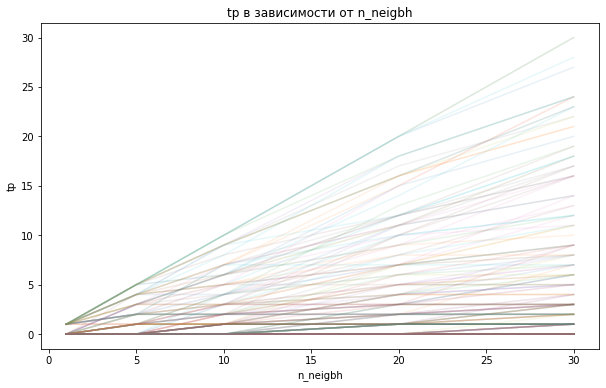

In [36]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["tp"], alpha=0.1)
plt.plot()
plt.title("tp в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("tp")
plt.show()

In [37]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.146789
5     0.138226
10    0.132110
20    0.130275
30    0.123955
Name: accuracy, dtype: float64

In [38]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.033333
5     0.037778
10    0.035556
20    0.035278
30    0.032593
Name: accuracy, dtype: float64

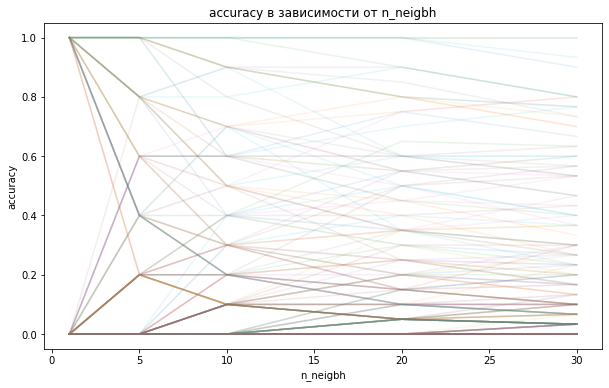

In [39]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["accuracy"], alpha=0.1)
plt.plot()
plt.title("accuracy в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("accuracy")
plt.show()

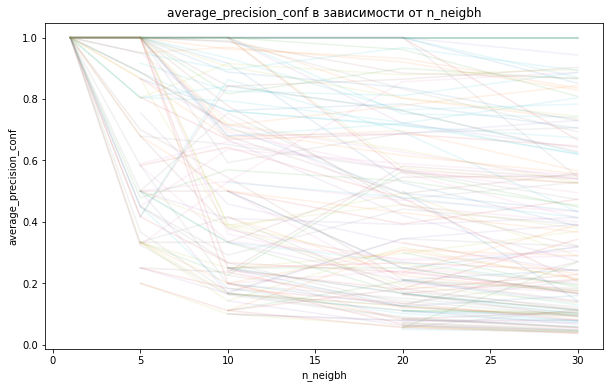

In [40]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_conf"], alpha=0.1)
plt.plot()
plt.title("average_precision_conf в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_conf")
plt.show()

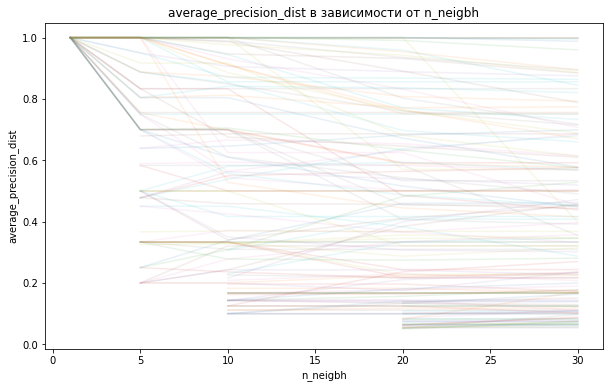

In [41]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_dist"], alpha=0.1)
plt.plot()
plt.title("average_precision_dist в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_dist")
plt.show()

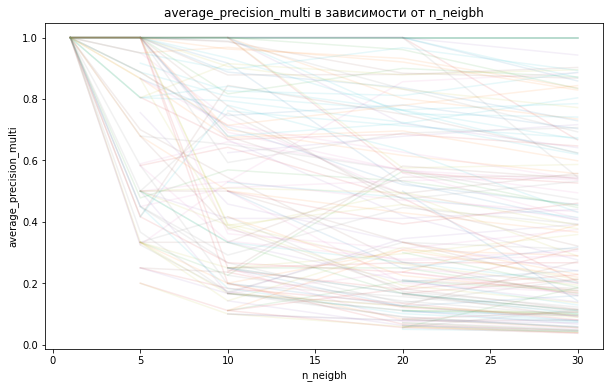

In [42]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_multi"], alpha=0.1)
plt.plot()
plt.title("average_precision_multi в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_multi")
plt.show()

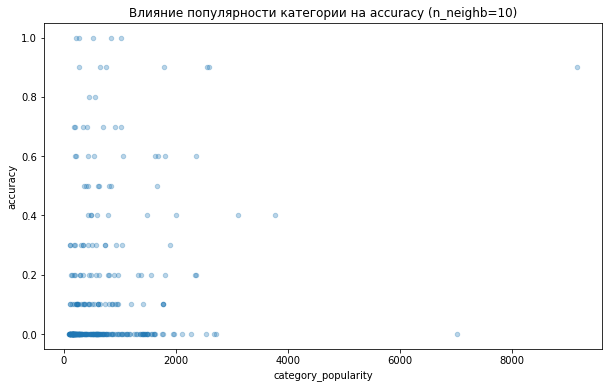

In [43]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на accuracy (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

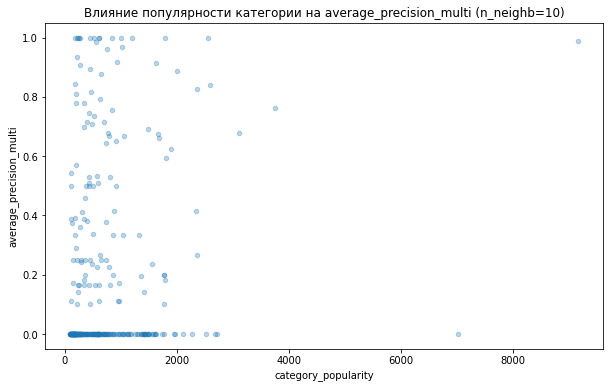

In [44]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

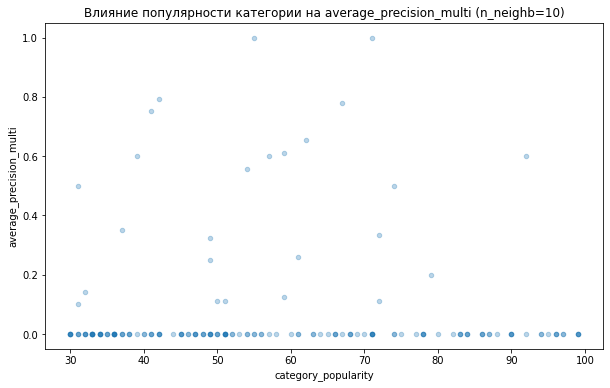

In [45]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

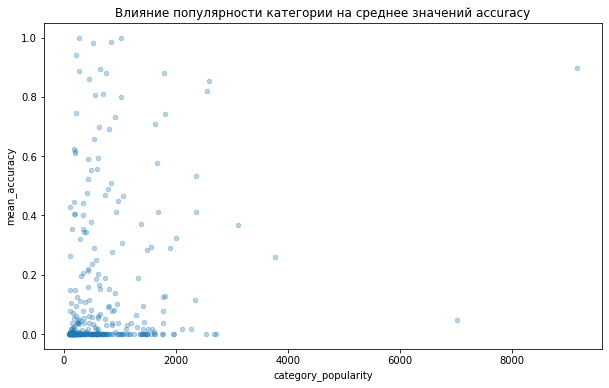

In [46]:
(
    metrics[metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .groupby(["category_id", "category_popularity"])["accuracy"]
    .mean()
    .reset_index(name="mean_accuracy")
    .plot(
        "category_popularity",
        "mean_accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на среднее значений accuracy",
        figsize=(10, 6),
    )
)
plt.show()

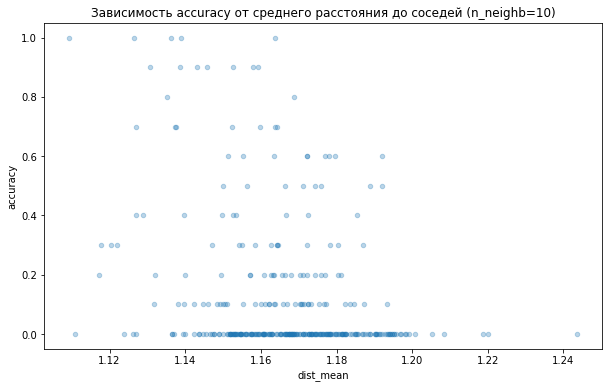

In [47]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "dist_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего расстояния до соседей (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

In [48]:
# top категорий по минимальному расстоянию до соседей (что хорошо знает clip)
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].sort_values("dist_mean").head(
    10
)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
2222,445,fireplug,10,1.000000,1.000000,...,10,1.109402,0.336446,0.858066,1.0
5097,1020,brake_light,10,NaN,NaN,...,0,1.110797,0.354810,NaN,0.0
4822,965,ski_boot,10,0.196429,0.700000,...,2,1.117198,0.288424,0.662886,0.2
5392,1079,tennis_racket,10,0.531746,0.277778,...,3,1.117794,0.413818,0.803079,0.3
6007,1202,zebra,10,0.333333,0.340741,...,3,1.120440,0.281590,0.698296,0.3
4877,976,snowboard,10,0.700000,0.527778,...,3,1.121852,0.312030,0.946002,0.3
3132,627,lamppost,10,NaN,NaN,...,0,1.123751,0.463197,NaN,0.0
4832,967,ski_pole,10,NaN,NaN,...,0,1.126183,0.042050,NaN,0.0
287,58,baseball_bat,10,1.000000,1.000000,...,10,1.126398,0.298141,0.878371,1.0
5622,1125,trunk,10,NaN,NaN,...,0,1.126874,0.421901,NaN,0.0


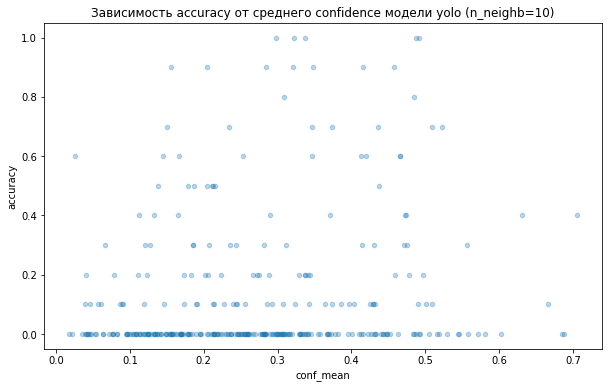

In [49]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

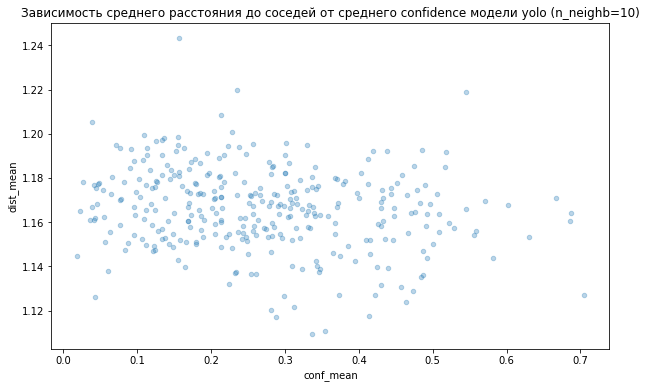

In [50]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "dist_mean",
        kind="scatter",
        alpha=0.3,
        title="Зависимость среднего расстояния до соседей от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

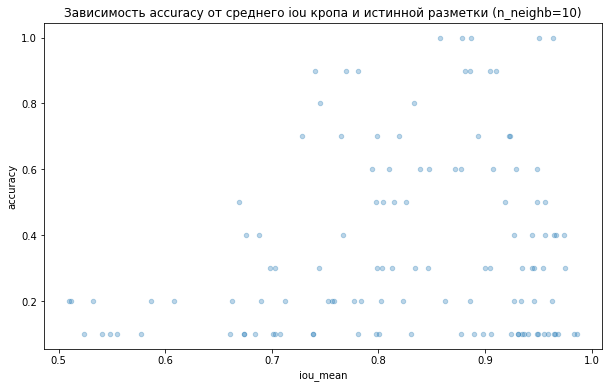

In [51]:
(
    metrics[
        (metrics["tp"] != 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
    ].plot(
        "iou_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего iou кропа и истинной разметки (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()